In [1]:
import torch

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


# 학습시작

### 라이브러리 import

In [2]:
import torch.nn as nn                     
import torch.nn.functional as F           # 손실함수

import torch.optim as optim               # optimizer
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import splitfolders as sf

from tqdm import tqdm
import torch.optim as optim

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import os

In [4]:
from glob import glob
import numpy as np

#### 설치

In [3]:
pip install tqdm

     |████████████████████████████████| 78 kB 1.1 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [108]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


### 난수 고정

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

### 데이터

##### 학습 데이터 분할하기

https://mgyo.tistory.com/75  
https://eunchankim-dev.tistory.com/55

In [8]:
# train 세트를 8:2비율로 validation 세트로 분할
sf.ratio("apple_dataset/train", output="apple_dataset/train_split", seed=656, ratio=(.8, .2))



Copying files: 0 files [00:00, ? files/s]

Copying files: 891 files [00:00, 8904.30 files/s]

Copying files: 1943 files [00:00, 9853.29 files/s]

Copying files: 3053 files [00:00, 10420.84 files/s]

Copying files: 4146 files [00:00, 10621.72 files/s]

Copying files: 5241 files [00:00, 10617.74 files/s]

Copying files: 6404 files [00:00, 10463.50 files/s]


##### 데이터 세트 불러오기

In [5]:
# 정규화 설정
transform = transforms.Compose( # 여러단계로 변환 시 묶어서 사용할 수 있게 함.
    [transforms.ToTensor(), # 데이터를 Tensor로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

batch_size = 13

# 데이터세트 불러오기
trainset = torchvision.datasets.ImageFolder(root = 'apple_dataset/train_split/train',
                                             transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.ImageFolder(root = 'apple_dataset/train_split/val',
                                             transform = transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


testset = torchvision.datasets.ImageFolder(root = 'apple_dataset/test',
                                             transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

In [6]:
# classes가 각 폴더를 배열 형태로 담음
len(classes)

13

### 데이터 세트 분석

---
1. 샘플
2. 크기
3. 개수
4. 비율
5. 분포


https://www.sas.com/ko_kr/solutions/ai-mic/blog/machine-learning-data-set.html

#### 개수

In [194]:
# 전체 이미지 개수 출력하기
train_list = glob('apple_dataset/train_split/train/Apple_*/**')
trian_file_list = glob('apple_dataset/train_split/train/Apple_*')
val_list = glob('apple_dataset/train_split/val/Apple_*/**')
test_list = glob('apple_dataset/test/Apple_*/**')

all_cnt = len(train_list) + len(val_list) + len(test_list)

print('전체 이미지의 개수 :', all_cnt)

# 학습 이미지 개수 확인하기
print('학습 이미지의 개수 :', len(train_list))
print('검증 이미지의 개수 :', len(val_list))
print('시험 이미지의 개수 :', len(test_list))

print()

print('학습 데이터 정보')
print('%14s' % '클래스명 %15s' % '개수 %5s' % '확장자')
for i in range(0, 13):
    file_name = str(trian_file_list[i])
    file_dir = os.listdir(trian_file_list[i])
    img_extension = os.path.splitext(file_dir[0])[1]
    print(f'{file_name[32:]:19s} /  {len(trian_file_list[i])}  / {img_extension}')

전체 이미지의 개수 : 8538
학습 이미지의 개수 : 5117
검증 이미지의 개수 : 1287
시험 이미지의 개수 : 2134

학습 데이터 정보
     클래스명          개수   확장자
Apple_Braeburn      /  46  / .jpg
Apple_Crimson_Snow  /  50  / .jpg
Apple_Golden1       /  45  / .jpg
Apple_Golden2       /  45  / .jpg
Apple_Golden3       /  45  / .jpg
Apple_Granny_Smith  /  50  / .jpg
Apple_Pink_Lady     /  47  / .jpg
Apple_Red1          /  42  / .jpg
Apple_Red2          /  42  / .jpg
Apple_Red3          /  42  / .jpg
Apple_Red_Delicious /  51  / .jpg
Apple_Red_Yellow1   /  49  / .jpg
Apple_Red_Yellow2   /  49  / .jpg


https://ndb796.tistory.com/658

#### 비율

In [196]:
a = len(train_list) / all_cnt
b = len(val_list) / all_cnt
c = len(test_list) / all_cnt

a + b + c

1.0

#### 샘플 출력

##### 튜토리얼

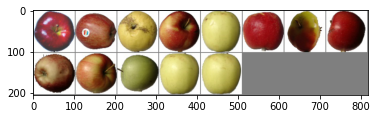

Apple_Red_Delicious / Apple_Red1 / Apple_Golden1 / Apple_Braeburn / Apple_Golden2 / Apple_Red_Yellow1 / Apple_Red_Yellow2 / Apple_Braeburn / Apple_Red3 / Apple_Red2 / Apple_Granny_Smith / Apple_Golden2 / Apple_Golden2


In [8]:
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    # .transpose : pytorch에서 [Batch Size, Channel, Width, Height] 순으로 저장 된것을 
    # 다시 [Width, Height, Channel]형태로 변경해줌
    plt.show()


# 학습용 이미지를 무작위로 가져오기 : suffle로 가져왔기 때문에 무작위.
dataiter = iter(trainloader)  # :iter타입으로 변경
images, labels = dataiter.next()  #iter 타입의 객체에서 값을 하나씩 뽑아옴

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' / '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [197]:
for i in range(0, 13) : 
    row =  (0 if i < 7 else 1)
    columns = i % 7
    print(row, " / ", columns)

0  /  0
0  /  1
0  /  2
0  /  3
0  /  4
0  /  5
0  /  6
1  /  0
1  /  1
1  /  2
1  /  3
1  /  4
1  /  5


##### 출력 형태 1

In [191]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

for i in range(0, 13) : 
    row = (0 if i < 7 else 1)
    columns = i % 7
    file_name = str(trian_file_list[i])
    images = glob(f'{trian_file_list[i]}/*')
        
    image = Image.open(''.join(f'{images[image_index]}'))
    plt_title = "{}".format(file_name[38:]) # image title
    plt.axes(rows, columns)
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.title(plt_title)   # title 
    plt.imshow(image)  
    plt.show()

TypeError: axes() takes from 0 to 1 positional arguments but 2 were given

##### 출력 형태 2 : 미완

In [ ]:
# 학습 데이터 세트 클래스당 이미지 5장 씩 뽑아와서 보여주기. 첫 colum에는 클래스명.

plt.rcParams['figure.figsize'] = (20.0, 20.0)

# images = glob('apple_dataset/train/**/10_100.jpg')

rows = 13
columns = 6

for i in range(0, 78):
    image_index = i + 1 
    file_name = str(trian_file_list[i])
    file_dir = os.listdir(trian_file_list[i])
    
    plt.subplot(rows, columns, image_index) # subplot 
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    
    if(image_index % 13 == 1):
        plt.text(10.0, 10.0, f'{file_name[32:]}')
        plt.savefig("out.png")
        
    else:
        image = Image.open(glob(f'{trian_file_list[i]}/*'))
        # // plt.axis('off')
        plt.xticks([])  # x = None 
        plt.yticks([])  # y = None
        plt.imshow(image)  
        
plt.show()

#### 분포 


https://velog.io/@katinon/%ED%98%BC%EA%B3%B5%EB%A8%B8%EC%8B%A0-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%97%90%EC%84%9C%EC%9D%98-%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5%EA%B3%BC-%EC%83%98%ED%94%8C%EB%A7%81-%ED%8E%B8%ED%96%A5

### 모델

#### 모델 불러오기

In [99]:
# mobilenetV3 불러오기
import torchvision.models as models

model = models.mobilenet_v3_small(num_classes=13).to(device)

In [ ]:
# 모델 정보 출력. 11개의 층으로 이루어짐.
model

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

#### 모델 학습

In [ ]:
criterion = nn.CrossEntropyLoss()   # 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # optimizer SGD(경사하강법)사용

In [ ]:

for epoch in range(2):   # 데이터셋을 수차례 반복합니다. epoch : 2 / batch_size : 13 (class  개수대로)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs.cuda())
        loss = criterion(outputs.cpu(), labels) # criterion : 손실함수
        loss.backward() # 자동 미분
        optimizer.step()
        # inputs = inputs.cpu()
        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}') # loss : loss 평균값 출력
                                                                      # .3f:소수점 3자리만 출력
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.950
[1,   200] loss: 1.861
[1,   300] loss: 1.631
[1,   400] loss: 1.458
[2,   100] loss: 1.142
[2,   200] loss: 0.982
[2,   300] loss: 0.812
[2,   400] loss: 0.657
Finished Training


##### 학습 현황 확인

https://gaussian37.github.io/dl-pytorch-observe/

#### 혼돈 행렬

##### 모델 평가 지표

https://rabo0313.tistory.com/entry/ML-%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-Confusion-Matrix-accuracy-precision-recall-f1-score-ROC-AUC-curve

https://skillmemory.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%B6%84%EB%A5%98-%ED%98%BC%EB%8F%99-%ED%96%89%EB%A0%ACConfusion-matrix

https://truman.tistory.com/179

#### 전체 데이터셋에 대해 어떻게 작동하는가

In [ ]:
outputs = model(images.cuda())

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(13)))

Predicted:  Apple Pink Lady Apple Red Yellow 2 Apple Pink Lady Apple Golden 1


#### 각 분류별 정확도 출력

In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = model(images.cuda())
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Apple Braeburn is 14.0 %
Accuracy for class: Apple Crimson Snow is 8.1 %
Accuracy for class: Apple Golden 1 is 8.1 %
Accuracy for class: Apple Golden 2 is 9.1 %
Accuracy for class: Apple Golden 3 is 3.7 %
Accuracy for class: Apple Granny Smith is 7.3 %
Accuracy for class: Apple Pink Lady is 7.2 %
Accuracy for class: Apple Red 1 is 9.8 %
Accuracy for class: Apple Red 2 is 7.3 %
Accuracy for class: Apple Red 3 is 13.9 %
Accuracy for class: Apple Red Delicious is 13.9 %
Accuracy for class: Apple Red Yellow 1 is 13.4 %
Accuracy for class: Apple Red Yellow 2 is 14.2 %
